**Summary:**

Train an adversarial patch to attack a single sample image of a peron.

#Imports

In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import json
import zipfile
import configparser

In [ ]:
%%capture
%%bash
git clone https://github.com/yanjiekee/adversarial_ki

In [ ]:
from adversarial_ki import dataset
from adversarial_ki import patch
from adversarial_ki import result

In [ ]:
result.init_drive()

Mounted at /content/drive


In [ ]:
# Clone the tensorflow models repository
%%capture
%%bash
git clone --depth 1 https://github.com/tensorflow/models
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
# Import some Object Detection API utility
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

In [ ]:
!pip install kaggle

# Define username and public api key gathered from your Kaggle Account
KAGGLE_USERNAME = 'eulerismygod'
KAGGLE_PUBLIC_API_KEY = '81c12f2b229dae9c3469e25df4c04838'
api_token = {"username":KAGGLE_USERNAME,"key":KAGGLE_PUBLIC_API_KEY}

!mkdir /root/.kaggle

# Create .kaggle/kaggle.json file at the root for Kaggle API reference
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Download dataset and extract it to adversarial-person/data
!chmod 600 root/.kaggle/kaggle.json
!kaggle datasets download -d jcoral02/inriaperson

with zipfile.ZipFile('inriaperson.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/inriaperson/')

!rm inriaperson.zip

In [ ]:
%matplotlib inline

#Configuration

In [ ]:
# COCO Dataset Category Index
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
CATEGORY_INDEX_COCO = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
CATEGORY_INDEX_SIZE = 90
CATEGORY_INDEX_PERSON_CLASS_ID = 1
CATEGORY_INDEX_MAL_CLASS_ID = 16  #Zebra class
CATEGORY_LABEL_ID_OFFSET = 1

# Dataset images
IMG_SIZE = 1024

# Loss functions definitions
RPN_LOCALISATION = "Loss/RPNLoss/localization_loss"
RPN_OBJECTNESS = "Loss/RPNLoss/objectness_loss"
CLASSIFIER_LOCALISATION = "Loss/BoxClassifierLoss/localization_loss"
CLASSIFIER_CLASSIFICATION = "Loss/BoxClassifierLoss/classification_loss"

In [ ]:
# Loss dictionary reference:
# RPN_LOCALISATION
# RPN_OBJECTNESS
# CLASSIFIER_LOCALISATION
# CLASSIFIER_CLASSIFICATION

# Adversarial patch
ADV_SIZE = 100
ADV_SIZE_RANDOM = False
ADV_LOCATION_RANDOM = False
ADV_ROTATION_RANDOM = False
ADV_BRIGHTNESS_RANDOM = False

# Loss function
LOSS_FUNCTION = "Max Person Class Prob"
LOSS_SAMPLING_RATE = 5

# Optimiser
OPTIMISER_ALG = "adam"

ADAM_LEARNING_RATE = 0.05
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON = 1e-07
ADAM_AMSGRAD = False

SGD_LEARNING_RATE = 0.1
SGD_MOMENTUM = 0.75
SGD_NESTEROV = False

# Training size
TEST_SET_RATIO = 0.2
NUMBER_OF_EPOCH = 25

# Learning rate scheduler
SCHEDULER_ALG = "none"

POLY_SCH_INITIAL_LEARNING_RATE = 5.0
POLY_SCH_DECAY_STEPS = 0  #Defined after dataset length is derived
POLY_SCH_END_LEARNING_RATE = 0.0001
POLY_SCH_POWER = 0.5
POLY_SCH_CYCLE = False

#Adversarial Patch

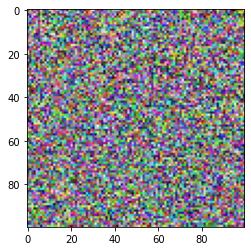

In [ ]:
def reset_patch(adv_patch, seed=14):
  init_patch = patch.init(random=True, random_seed=seed)
  adv_patch.assign(init_patch)

adversarial_patch_init_value = patch.init()

adversarial_patch = tf.Variable(initial_value=adversarial_patch_init_value, 
                                trainable=True, 
                                dtype=tf.float32)
reset_patch(adversarial_patch)
patch.show(adversarial_patch)

#Debug

In [ ]:
def filter_dataset_files(dir):
  """Remove part of the dataset files for quicker debug
  """
  directory = os.fsencode(dir)
  for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if not filename.startswith("person_and_bike"):
      os.remove(os.path.join(dir, filename))
      continue
    else:
      continue

#Sanity Check Utils


In [ ]:
def return_plot_detections(img, boxes, classes, scores, category_index, threshold=0.8):
  """Wrapper function for visualize_boxes_and_labels_on_image_array,
  Instead of printing it, return the image, delaying the printing
  """
  image_np_with_annotations = img.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold,
      line_thickness=8)
  
  return image_np_with_annotations

In [ ]:
def plot_detections(img, boxes, classes, scores, category_index, threshold=0.8, size=(6, 6)):
  """Wrapper function for visualize_boxes_and_labels_on_image_array"""
  image_np_with_annotations = return_plot_detections(img, boxes, classes, scores, category_index, threshold)
  
  plt.figure(figsize=size)
  plt.imshow(image_np_with_annotations)

In [ ]:
def dataset_sanity_check(img_list_ts, box_list_np, class_list_np, category_index, index=None):

  print("Image list length:   ", len(img_list_ts))
  print("Boxes list length:   ", len(box_list_np))
  print("Classes list length: ", len(class_list_np))

  length = len(img_list_ts)

  if index is None:
    index = random.randrange(length)
  elif index >= length:
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(length)

  img = img_list_ts[index].numpy().astype(np.int32)[0]
  boxes = box_list_np[index]
  classes = class_list_np[index].astype(np.uint32)
  scores = np.ones(shape=(len(classes)))

  plot_detections(img, boxes, classes, scores, category_index)

In [ ]:
def detection_model_sanity_check(model, img_list_ts, category_index, index=None):
  """Plot the detection boxes of a selected image
  """

  if index is None:
    index = random.randrange(len(img_list_ts))
  elif index >= len(img_list_ts):
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(len(img_list_ts))

  index = random.randrange(len(img_list_ts))
  img = img_list_ts[index].numpy().astype(np.uint32)[0]

  detections = detect(img_list_ts[index])

  plot_detections(
      img,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + CATEGORY_LABEL_ID_OFFSET,
      detections['detection_scores'][0].numpy(),
      category_index)

In [ ]:
def result_sanity_check(model, img_list_ts, adv_box_ts, adv_patch, category_index, index=None, threshold=0.8):
  """Verify adversarial patch by comparing the before and after adversarial
  patch is attached to an image
  """

  if index is None:
    index = random.randrange(len(img_list_ts))
  elif index >= len(img_list_ts):
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(len(img_list_ts))

  img = img_list_ts[index].numpy().astype(np.uint32)[0]

  # Before
  detections = detect(img_list_ts[index])
  
  genuine_detection = return_plot_detections(
      img,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + CATEGORY_LABEL_ID_OFFSET,
      detections['detection_scores'][0].numpy(),
      category_index)
  
  # After
  adv_mask = patch.transform(adv_box_ts[index], adv_patch)
  adv_img = patch.apply(img_list_ts[index], adv_mask)
  adv_detections = detect(adv_img)

  adv_img = adv_img.numpy().astype(int)[0].copy()

  mallicious_detection = return_plot_detections(
      adv_img,
      adv_detections['detection_boxes'][0].numpy(),
      adv_detections['detection_classes'][0].numpy().astype(np.uint32) + CATEGORY_LABEL_ID_OFFSET,
      adv_detections['detection_scores'][0].numpy(),
      category_index,
      threshold=threshold)
  
  # Print detections
  fig, axes = plt.subplots(1, 2, figsize=(20,10))
  axes[0].imshow(genuine_detection)
  axes[1].imshow(mallicious_detection)

#Config Utilities


In [ ]:
def store_config(dir):
  config = configparser.ConfigParser()

  config['ADV_PATCH'] = {}
  adv_config = config['ADV_PATCH']
  adv_config['SIZE'] = str(ADV_SIZE)
  adv_config['SIZE_RANDOM'] = str(ADV_SIZE_RANDOM)
  adv_config['LOCATION_RANDOM'] = str(ADV_LOCATION_RANDOM)
  adv_config['ROTATION_RANDOM'] = str(ADV_ROTATION_RANDOM)
  adv_config['BRIGHTNESS_RANDOM'] = str(ADV_BRIGHTNESS_RANDOM)

  config['LOSS_FUNC'] = {}
  loss_config = config['LOSS_FUNC']
  loss_config['TYPE'] = str(LOSS_FUNCTION)
  loss_config['SAMPLING_RATE'] = str(LOSS_SAMPLING_RATE)

  config['OPTIMISER'] = {}
  optimiser_config = config['OPTIMISER']
  if OPTIMISER_ALG == "adam":
    optimiser_config['ADAM_LEARNING_RATE'] = str(ADAM_LEARNING_RATE)
    optimiser_config['ADAM_BETA_1'] = str(ADAM_BETA_1)
    optimiser_config['ADAM_BETA_2'] = str(ADAM_BETA_2)
    optimiser_config['ADAM_EPSILON'] = str(ADAM_EPSILON)
    optimiser_config['ADAM_AMSGRAD'] = str(ADAM_AMSGRAD)
  elif OPTIMISER_ALG == "sgd":
    if SCHEDULER_ALG == None:
      optimiser_config['SGD_LEARNING_RATE'] = str(SGD_LEARNING_RATE)
    optimiser_config['SGD_MOMENTUM'] = str(SGD_MOMENTUM)
    optimiser_config['SGD_NESTEROV'] = str(SGD_NESTEROV)

  if SCHEDULER_ALG != None:
    config['SCHEDULER'] = {}
    scheduler_config = config['SCHEDULER']
    if SCHEDULER_ALG == "polynomial_decay":
      scheduler_config['POLY_SCH_INITIAL_LEARNING_RATE'] = str(POLY_SCH_INITIAL_LEARNING_RATE)
      scheduler_config['POLY_SCH_DECAY_STEPS'] = str(POLY_SCH_DECAY_STEPS)
      scheduler_config['POLY_SCH_END_LEARNING_RATE'] = str(POLY_SCH_END_LEARNING_RATE)
      scheduler_config['POLY_SCH_POWER'] = str(POLY_SCH_POWER)
      scheduler_config['POLY_SCH_CYCLE'] = str(POLY_SCH_CYCLE)

  config['TRAINING_LOOP'] = {}
  training_loop_config = config['TRAINING_LOOP']
  training_loop_config['NUMBER_OF_EPOCH'] = str(NUMBER_OF_EPOCH)

  with open(dir + '/training.ini', 'w') as configfile:
    config.write(configfile)

#Model

In [ ]:
# Model selection
MODEL_NAME_LIST = [
                   'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
                   'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8',
                   'faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8',
                   'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8',
                   'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8',
                   'faster_rcnn_resnet101_v1_800x1333_coco17_gpu-8'
]

In [ ]:
def download_model(model_name, model_date):
  """Downloaded files are stored in Keras cache"""
  base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(fname=model_name,
                                      origin=base_url + model_date + '/' + model_file,
                                      untar=True)
  return str(model_dir)

# Download and extract model
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

# Load pipeline config and build a detection model
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

353902592/353893393 [==============================] - 8s 0us/step


In [ ]:
# Create a graph execution for faster future use
@tf.function
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

#Dataset

In [ ]:
# Dateset directories
img_dir_1 = '/content/data/inriaperson/Train/JPEGImages'
img_dir_2 = '/content/data/inriaperson/Test/JPEGImages'

# Fetch dataset
img_1_np = dataset.fetch(img_dir_1)
img_2_np = dataset.fetch(img_dir_2)
img_np = img_1_np + img_2_np
del(img_1_np)
del(img_2_np)

# Tensorfy images
img_ts = dataset.tensorfy_and_resize_img(img_np, IMG_SIZE)
del(img_np)

# Label dataset
label_dataset_fn = dataset.get_label_dataset_fn(detection_model, IMG_SIZE, label_threshold=0.9)
box_np, class_np = label_dataset_fn(img_ts)

# Filter dataset
img_ts, box_np, class_np = dataset.filter_detection_count(img_ts, box_np, class_np, min=1, max=5)
img_ts, box_np, class_np = dataset.filter_person_count(img_ts, box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID, min=1, max=3)

# Generate mallicious groundtruths
mal_class_np, adv_box_np = dataset.generate_mallicious_classification_gt(box_np, class_np, CATEGORY_INDEX_PERSON_CLASS_ID, CATEGORY_INDEX_MAL_CLASS_ID)

# Second-stage filtering
# img_ts, box_np, mal_class_np, adv_box_np = dataset.filter_large_iou(img_ts, box_np, mal_class_np, adv_box_np, iou_threshold=0.4)

# Tensorfy groundtruths
box_ts, mal_class_ts, adv_box_ts = dataset.tensorfy_gt(box_np, mal_class_np, adv_box_np, CATEGORY_INDEX_SIZE)
del(box_np)
del(mal_class_np)
del(adv_box_np)

#DEBUG
print(f"DEBUG: Dataset size={len(img_ts)}")

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.
DEBUG: Dataset size=430


In [ ]:
# Spilting into train and test sets
(train_img_ts, train_box_ts, train_class_ts, train_adv_box_ts, 
 test_img_ts, test_box_ts, test_class_ts, test_adv_box_ts) = dataset.split(img_ts, 
                                                                           box_ts, 
                                                                           mal_class_ts, 
                                                                           adv_box_ts, 
                                                                           TEST_SET_RATIO)
training_set_size = len(train_img_ts)
print(f"DEBUG: Training Set Size={training_set_size}")
del(img_ts)
del(box_ts)
del(mal_class_ts)
del(adv_box_ts)

DEBUG: Training Set Size=344


In [ ]:
TRAINING_SET_SIZE = len(train_img_ts)
TEST_SET_SIZE = len(test_img_ts)

print(f"DEBUG: Training Set Size={TRAINING_SET_SIZE}")
print(f"DEBUG: Test Set Size    ={TEST_SET_SIZE}")

DEBUG: Training Set Size=344
DEBUG: Test Set Size    =86


In [ ]:
POLY_SCH_DECAY_STEPS = NUMBER_OF_EPOCH * TRAINING_SET_SIZE

#Training Init



In [ ]:
@tf.function
def get_iou(box1, box2):
  """Calculate the Intersection over Union between two bounding box
  """
  ymin1, xmin1, ymax1, xmax1 = tf.unstack(box1 * 100, axis=0)
  ymin2, xmin2, ymax2, xmax2 = tf.unstack(box2 * 100, axis=0)

  x_overlap = tf.math.maximum(0.0, (tf.math.minimum(xmax1, xmax2) - tf.math.maximum(xmin1, xmin2)))
  y_overlap = tf.math.maximum(0.0, (tf.math.minimum(ymax1, ymax2) - tf.math.maximum(ymin1, ymin2)))
  area_intersect = x_overlap * y_overlap

  area_box1 = (xmax1 - xmin1) * (ymax1 - ymin1)
  area_box2 = (xmax2 - xmin2) * (ymax2 - ymin2)
  area_union = area_box1 + area_box2 - area_intersect

  iou = area_intersect / area_union
  return iou

In [ ]:
@tf.function
def highest_person_class_prob_and_iou(adv_target_box, class_predictions_with_background, proposal_boxes):
  iou = tf.TensorArray(dtype=tf.float32, size=300)
  for id in range(300):
    iou = iou.write(id, get_iou(adv_target_box, proposal_boxes[id]))

  iou = iou.stack()
  highest_prob = tf.reduce_max(tf.transpose(tf.nn.softmax(class_predictions_with_background))[CATEGORY_INDEX_PERSON_CLASS_ID] * iou)

  return highest_prob

# @tf.function
# def highest_person_class_prob(class_predictions_with_background):
#   highest_prob = tf.reduce_max(tf.transpose(tf.nn.softmax(class_predictions_with_background))[CATEGORY_INDEX_PERSON_CLASS_ID])
#   return highest_prob

In [ ]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimiser):
  """Get a tf.function for training step."""

  @tf.function
  def train_step_fn(image_tensors, targeted_box):
    """A single training iteration.

    Args:
      image_tensors: A [1, height, width, 3] Tensor of type tf.float32.
      targeted_box: A Tensor of shape [4] with type tf.float32

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    
    with tf.GradientTape() as tape:

      tape.watch(adversarial_patch)

      # NOTE: Assumption - image tensors only contain single image tensor
      adv_mask = patch.transform(box=targeted_box, 
                                 patch=adversarial_patch,
                                 mask_width=tf.constant(IMG_SIZE, tf.float32),
                                 random_size=tf.constant(ADV_SIZE_RANDOM, tf.bool),
                                 random_location=tf.constant(ADV_LOCATION_RANDOM, tf.bool))
      adv_image_tensors = patch.apply(image_tensors, adv_mask)
      preprocessed_images, shapes = model.preprocess(adv_image_tensors)
      prediction_dict = model.predict(preprocessed_images, shapes)

      loss = highest_person_class_prob_and_iou(targeted_box,
                                               prediction_dict['class_predictions_with_background'],
                                               tf.squeeze(prediction_dict['proposal_boxes']/1024))

      gradients = tape.gradient(loss, adversarial_patch)
      optimiser.apply_gradients(zip([gradients], [adversarial_patch]))

      # Clip value to valid RGB range [0, 1]
      adversarial_patch.assign(tf.clip_by_value(adversarial_patch, clip_value_min=0, clip_value_max=1))

    return loss

  return train_step_fn

In [ ]:
# Get training step
if OPTIMISER_ALG == "adam":
  optimiser = tf.keras.optimizers.Adam(
      learning_rate=ADAM_LEARNING_RATE,
      beta_1=ADAM_BETA_1,
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON,
      amsgrad=ADAM_AMSGRAD,
  )
elif OPTIMISER_ALG == "sgd":

  if SCHEDULER_ALG == None:
    learning_rate=SGD_LEARNING_RATE

  elif SCHEDULER_ALG == "polynomial_decay":
    learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=POLY_SCH_INITIAL_LEARNING_RATE,
        decay_steps=POLY_SCH_DECAY_STEPS,
        end_learning_rate=POLY_SCH_END_LEARNING_RATE,
        power=POLY_SCH_POWER,
        cycle=POLY_SCH_CYCLE
    )

  optimiser = tf.keras.optimizers.SGD(
      learning_rate=learning_rate,
      momentum=SGD_MOMENTUM,
      nesterov=SGD_NESTEROV
  )

train_step_fn = get_model_train_step_function(detection_model, optimiser)

#Training Loop

In [ ]:
import time
import datetime

# Run training
loss_history = []
start = time.process_time()

for i in range(NUMBER_OF_EPOCH):
  if i is 0:
    train_img = train_img_ts[0]
    train_adv_box = train_adv_box_ts[0]
    debug_loss = train_step_fn(train_img, train_adv_box)
    print(f"debug_loss={debug_loss}\n")
  
  if i > 0:
    # Debug
    ct = datetime.datetime.now()
    time_taken = time.process_time() - start
    seconds_remaining = time_taken / i * (NUMBER_OF_EPOCH-i)
    mins_remaining = int(seconds_remaining / 60)
    hours_remaining = int(mins_remaining / 60)

    print(f"epoch={i}, latest loss={loss.numpy()}")
    print(f"time={ct.hour}:{ct.minute}, estimated complete in... {hours_remaining} h {mins_remaining - hours_remaining*60} min\n")

  for j in range(TRAINING_SET_SIZE):
    train_img = train_img_ts[j]
    train_adv_box = train_adv_box_ts[j]
    loss = train_step_fn(train_img, train_adv_box)
    
    if (i*TRAINING_SET_SIZE + j) % LOSS_SAMPLING_RATE == 0:
      loss_history.append(loss.numpy())


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Gather/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Slice_1:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Gather

debug_loss=0.9093873500823975

epoch=1, latest loss=0.8284801244735718
time=12:58, estimated complete in... 1 h 3 min

epoch=2, latest loss=0.6706962585449219
time=13:1, estimated complete in... 0 h 54 min

epoch=3, latest loss=0.6733438968658447
time=13:4, estimated complete in... 0 h 49 min

epoch=4, latest loss=0.6439948678016663
time=13:7, estimated complete in... 0 h 46 min

epoch=5, latest loss=0.6151607036590576
time=13:10, estimated complete in... 0 h 43 min

epoch=6, latest loss=0.6693370342254639
time=13:12, estimated complete in... 0 h 41 min

epoch=7, latest loss=0.5964305996894836
time=13:15, estimated complete in... 0 h 38 min

epoch=8, latest loss=0.5843333601951599
time=13:18, estimated complete in... 0 h 36 min

epoch=9, latest loss=0.6645070910453796
time=13:21, estimated complete in... 0 h 34 min

epoch=10, latest loss=0.6686541438102722
time=13:24, estimated complete in... 0 h 31 min

epoch=11, latest loss=0.7009904980659485
time=13:26, estimated complete in... 0 h 

#Result

In [ ]:
plt.rc('font', size=30, family='serif') #controls default text size

In [ ]:
result_dir = result.init()

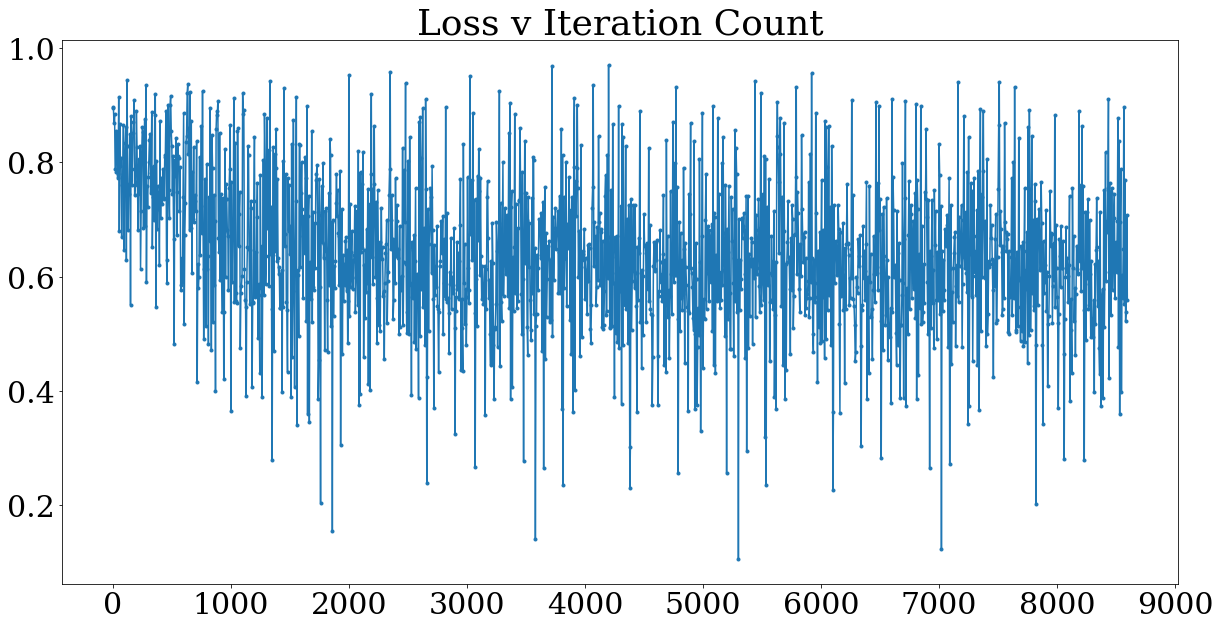

In [ ]:
def log_result(dir):
  record_dir = result.new_record(dir)
  store_config(record_dir)
  result.store_adv_checkpoint(adversarial_patch, record_dir)
  result.store_loss_history_csv(loss_history, LOSS_SAMPLING_RATE, record_dir)
  result.print_and_save_loss_history_plot(loss_history, LOSS_SAMPLING_RATE, record_dir, size=(20,10))

log_result(result_dir)

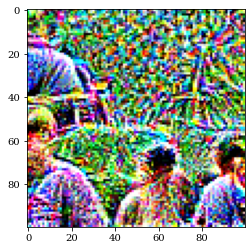

In [ ]:
plt.rc('font', size=10, family='serif') #controls default text size
patch.show(adversarial_patch)

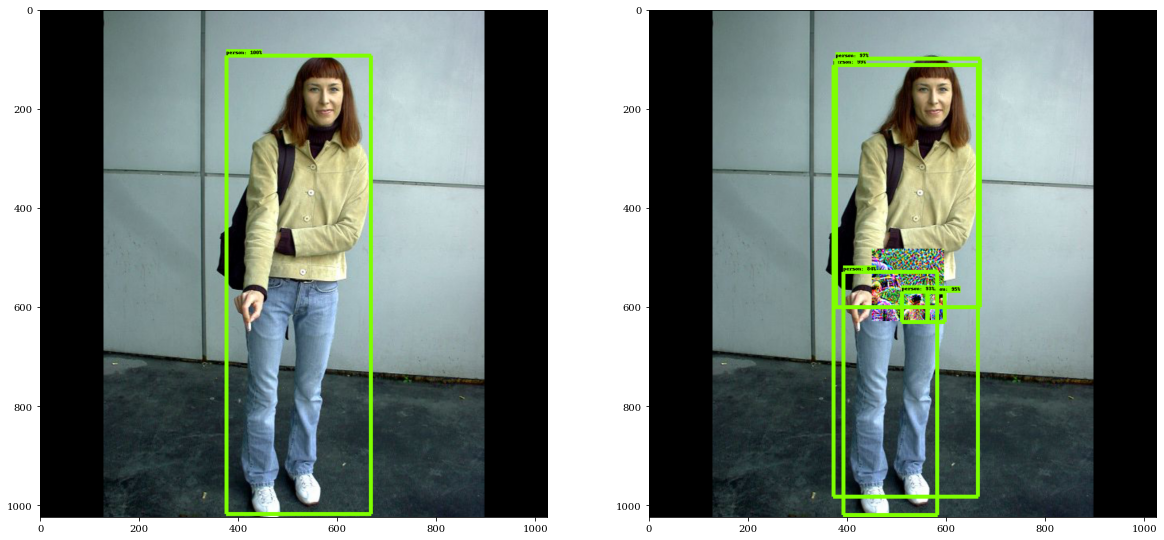

In [ ]:
result_sanity_check(detection_model, test_img_ts, test_adv_box_ts, adversarial_patch, CATEGORY_INDEX_COCO, threshold=0.75)

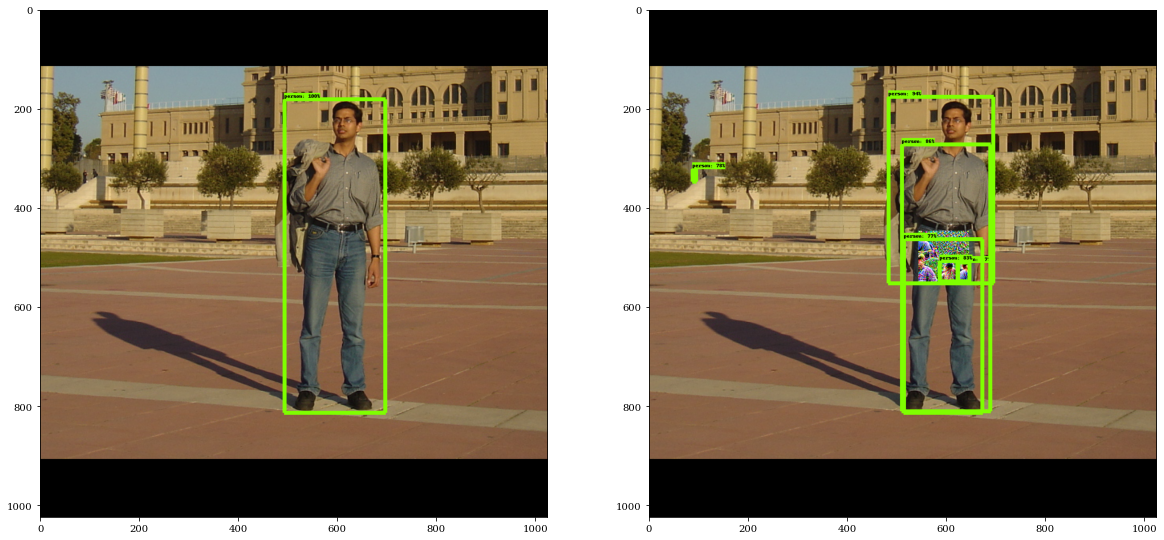

In [ ]:
result_sanity_check(detection_model, train_img_ts, train_adv_box_ts, adversarial_patch, CATEGORY_INDEX_COCO, threshold=0.75)

#Test

In [ ]:
# Set up forward pass for a single test step.
def get_model_test_step_function(model):
  """Get a tf.function for training step."""

  @tf.function
  def test_step_fn(image_tensors, targeted_box):
    """A single training iteration.

    Args:
      image_tensors: A [1, height, width, 3] Tensor of type tf.float32.
      targeted_box: A Tensor of shape [4] with type tf.float32

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    
    with tf.GradientTape() as tape:

      tape.watch(adversarial_patch)

      # NOTE: Assumption - image tensors only contain single image tensor
      adv_mask = patch.transform(box=targeted_box, 
                                 patch=adversarial_patch,
                                 mask_width=tf.constant(IMG_SIZE, tf.float32),
                                 random_size=tf.constant(ADV_SIZE_RANDOM, tf.bool),
                                 random_location=tf.constant(ADV_LOCATION_RANDOM, tf.bool))
      adv_image_tensors = patch.apply(image_tensors, adv_mask)
      preprocessed_images, shapes = model.preprocess(adv_image_tensors)
      prediction_dict = model.predict(preprocessed_images, shapes)

      loss = highest_person_class_prob_and_iou(targeted_box,
                                               prediction_dict['class_predictions_with_background'],
                                               tf.squeeze(prediction_dict['proposal_boxes']/1024))

    return loss

  return test_step_fn

test_step_fn = get_model_test_step_function(detection_model)

# Last epoch average
train_set_size = len(train_img_ts)

train_losses = []

for i in range(train_set_size):
  train_img = train_img_ts[i]
  train_adv_box = train_adv_box_ts[i]

  train_loss = test_step_fn(train_img, train_adv_box)
  train_losses.append(train_loss)

training_loss_error = sum(train_losses) / len(train_losses)
print(f"Last Epoch Average={training_loss_error}")


# Testing
test_set_size = len(test_img_ts)

test_losses = []

for i in range(test_set_size):
  test_img = test_img_ts[i]
  test_adv_box = test_adv_box_ts[i]

  test_loss = test_step_fn(test_img, test_adv_box)
  test_losses.append(test_loss)

generalisation_error = sum(test_losses) / len(test_losses)
print(f"Generalisation Error={generalisation_error}")

Last Epoch Average=0.6096546053886414
Generalisation Error=0.6087007522583008
